# MobileNetV3 Trash Classification Experiment

This notebook implements a trash classification model using MobileNetV3 architecture. The dataset contains images organized by trash bin colors: Black, Blue, Green, and TTR (possibly "Trash, Recycling, Recycle" or similar).

## 1. Import Required Libraries

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from PIL import Image

In [2]:
# Set style for better visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 2. Dataset Configuration and Paths

In [3]:
# Define dataset paths
dataset_root = Path("../dataset")
train_dir = dataset_root / "CVPR_2024_dataset_Train"
val_dir = dataset_root / "CVPR_2024_dataset_Val"
test_dir = dataset_root / "CVPR_2024_dataset_Test"

# Verify paths exist
print("Dataset directories:")
print(f"Train: {train_dir.exists()} - {train_dir}")
print(f"Val: {val_dir.exists()} - {val_dir}")
print(f"Test: {test_dir.exists()} - {test_dir}")

# Get class names
class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
num_classes = len(class_names)
print(f"\nClasses ({num_classes}): {class_names}")

Dataset directories:
Train: True - ..\dataset\CVPR_2024_dataset_Train
Val: True - ..\dataset\CVPR_2024_dataset_Val
Test: True - ..\dataset\CVPR_2024_dataset_Test

Classes (4): ['Black', 'Blue', 'Green', 'TTR']


## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Statistics

In [5]:
# Count images in each split and class
def count_images(directory):
    """Count images per class in a directory."""
    class_counts = {}
    for class_dir in sorted(directory.iterdir()):
        if class_dir.is_dir():
            # Count image files (jpg, jpeg, png)
            image_files = (
                list(class_dir.glob("*.jpg"))
                + list(class_dir.glob("*.jpeg"))
                + list(class_dir.glob("*.png"))
            )
            class_counts[class_dir.name] = len(image_files)
    return class_counts


# Get counts for each split
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Display statistics
print("Dataset Statistics:")
print("=" * 60)
print(f"{'Class':<15} {'Train':<12} {'Val':<12} {'Test':<12} {'Total':<12}")
print("-" * 60)

total_train = 0
total_val = 0
total_test = 0

for class_name in class_names:
    train_c = train_counts.get(class_name, 0)
    val_c = val_counts.get(class_name, 0)
    test_c = test_counts.get(class_name, 0)
    total_c = train_c + val_c + test_c

    total_train += train_c
    total_val += val_c
    total_test += test_c

    print(f"{class_name:<15} {train_c:<12} {val_c:<12} {test_c:<12} {total_c:<12}")

print("-" * 60)
print(
    f"{'Total':<15} {total_train:<12} {total_val:<12} {total_test:<12} {total_train + total_val + total_test:<12}"
)
print("=" * 60)

Dataset Statistics:
Class           Train        Val          Test         Total       
------------------------------------------------------------
Black           14           5            5            24          
Blue            14           5            5            24          
Green           14           5            5            24          
TTR             14           5            5            24          
------------------------------------------------------------
Total           56           20           20           96          


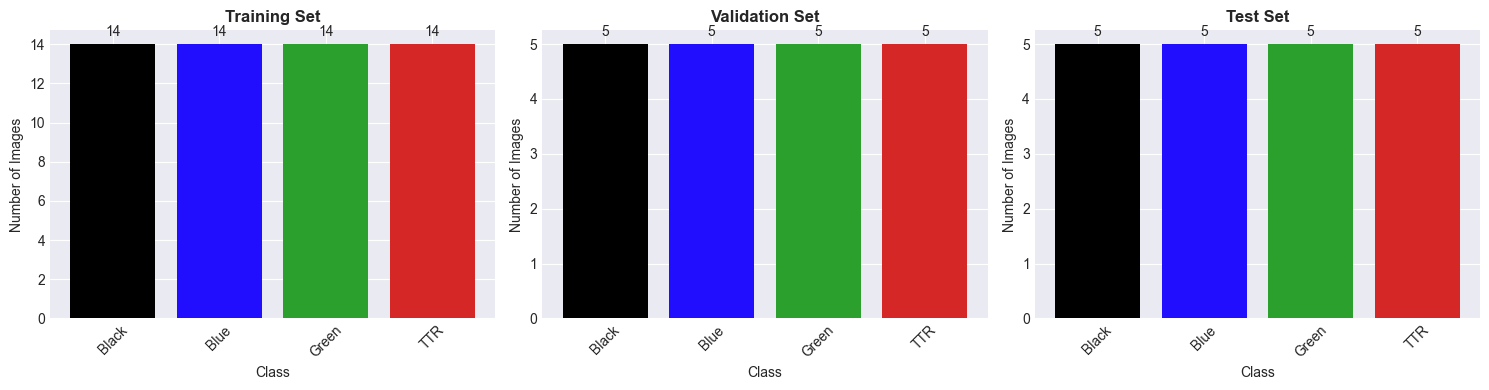


Class Balance Analysis:
Imbalance Ratio (max/min): 1.00


In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets_info = [
    ("Training Set", train_counts),
    ("Validation Set", val_counts),
    ("Test Set", test_counts),
]

for idx, (title, counts) in enumerate(datasets_info):
    classes = list(counts.keys())
    values = list(counts.values())

    axes[idx].bar(classes, values, color=["#000000", "#220eff", "#2ca02c", "#d62727"])
    axes[idx].set_title(title, fontsize=12, fontweight="bold")
    axes[idx].set_xlabel("Class")
    axes[idx].set_ylabel("Number of Images")
    axes[idx].tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(i, v + max(values) * 0.02, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Check for class imbalance
print("\nClass Balance Analysis:")
total_per_class = {
    cls: train_counts.get(cls, 0) + val_counts.get(cls, 0) + test_counts.get(cls, 0)
    for cls in class_names
}
max_count = max(total_per_class.values())
min_count = min(total_per_class.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float("inf")

print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print(
        "⚠️  Significant class imbalance detected. Consider using weighted loss or data augmentation."
    )

### 3.2 Sample Image Analysis

In [ ]:
# Analyze image properties


def analyze_images(directory, num_samples=100):
    """Analyze image dimensions and properties."""
    widths = []
    heights = []
    aspect_ratios = []

    count = 0
    for class_dir in directory.iterdir():
        if class_dir.is_dir():
            image_files = (
                list(class_dir.glob("*.jpg"))
                + list(class_dir.glob("*.jpeg"))
                + list(class_dir.glob("*.png"))
            )

            for img_path in image_files[: num_samples // len(class_names)]:
                try:
                    with Image.open(img_path) as img:
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                        aspect_ratios.append(w / h)
                        count += 1
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return widths, heights, aspect_ratios, count


print("Analyzing sample images from training set...")
widths, heights, aspect_ratios, analyzed_count = analyze_images(
    train_dir, num_samples=200
)

print(f"\nAnalyzed {analyzed_count} images")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(
    f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}"
)
print(
    f"Aspect Ratio - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}"
)

Analyzing sample images from training set...

Analyzed 56 images
Width  - Min: 375, Max: 4032, Mean: 1153.1
Height - Min: 413, Max: 3024, Mean: 1484.9
Aspect Ratio - Min: 0.53, Max: 1.78, Mean: 0.79


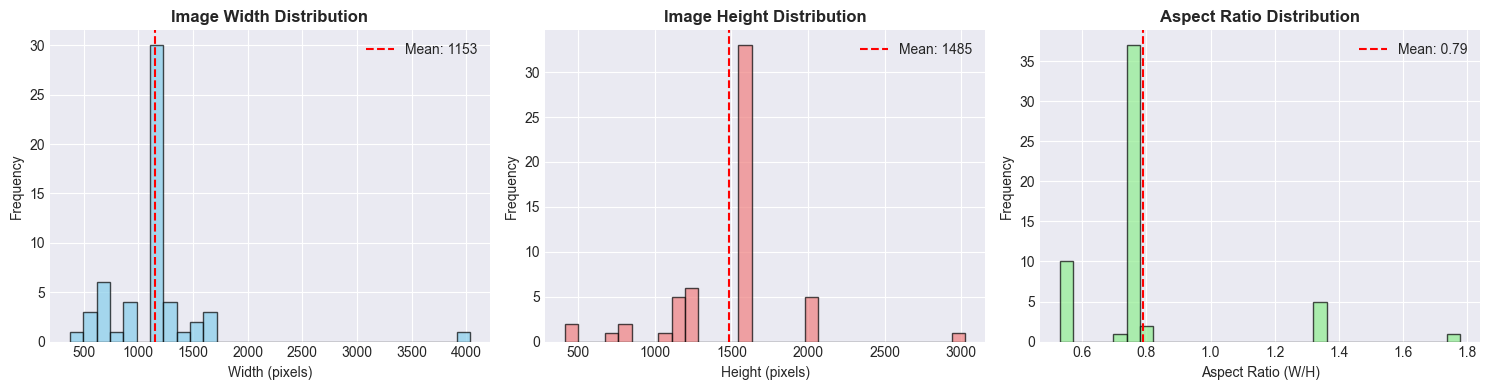

In [ ]:
# Visualize image dimension distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Image Width Distribution", fontweight="bold")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Frequency")
axes[0].axvline(
    np.mean(widths), color="red", linestyle="--", label=f"Mean: {np.mean(widths):.0f}"
)
axes[0].legend()

# Height distribution
axes[1].hist(heights, bins=30, color="lightcoral", edgecolor="black", alpha=0.7)
axes[1].set_title("Image Height Distribution", fontweight="bold")
axes[1].set_xlabel("Height (pixels)")
axes[1].set_ylabel("Frequency")
axes[1].axvline(
    np.mean(heights), color="red", linestyle="--", label=f"Mean: {np.mean(heights):.0f}"
)
axes[1].legend()

# Aspect ratio distribution
axes[2].hist(aspect_ratios, bins=30, color="lightgreen", edgecolor="black", alpha=0.7)
axes[2].set_title("Aspect Ratio Distribution", fontweight="bold")
axes[2].set_xlabel("Aspect Ratio (W/H)")
axes[2].set_ylabel("Frequency")
axes[2].axvline(
    np.mean(aspect_ratios),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(aspect_ratios):.2f}",
)
axes[2].legend()

plt.tight_layout()
plt.show()

### 3.3 Visualize Sample Images

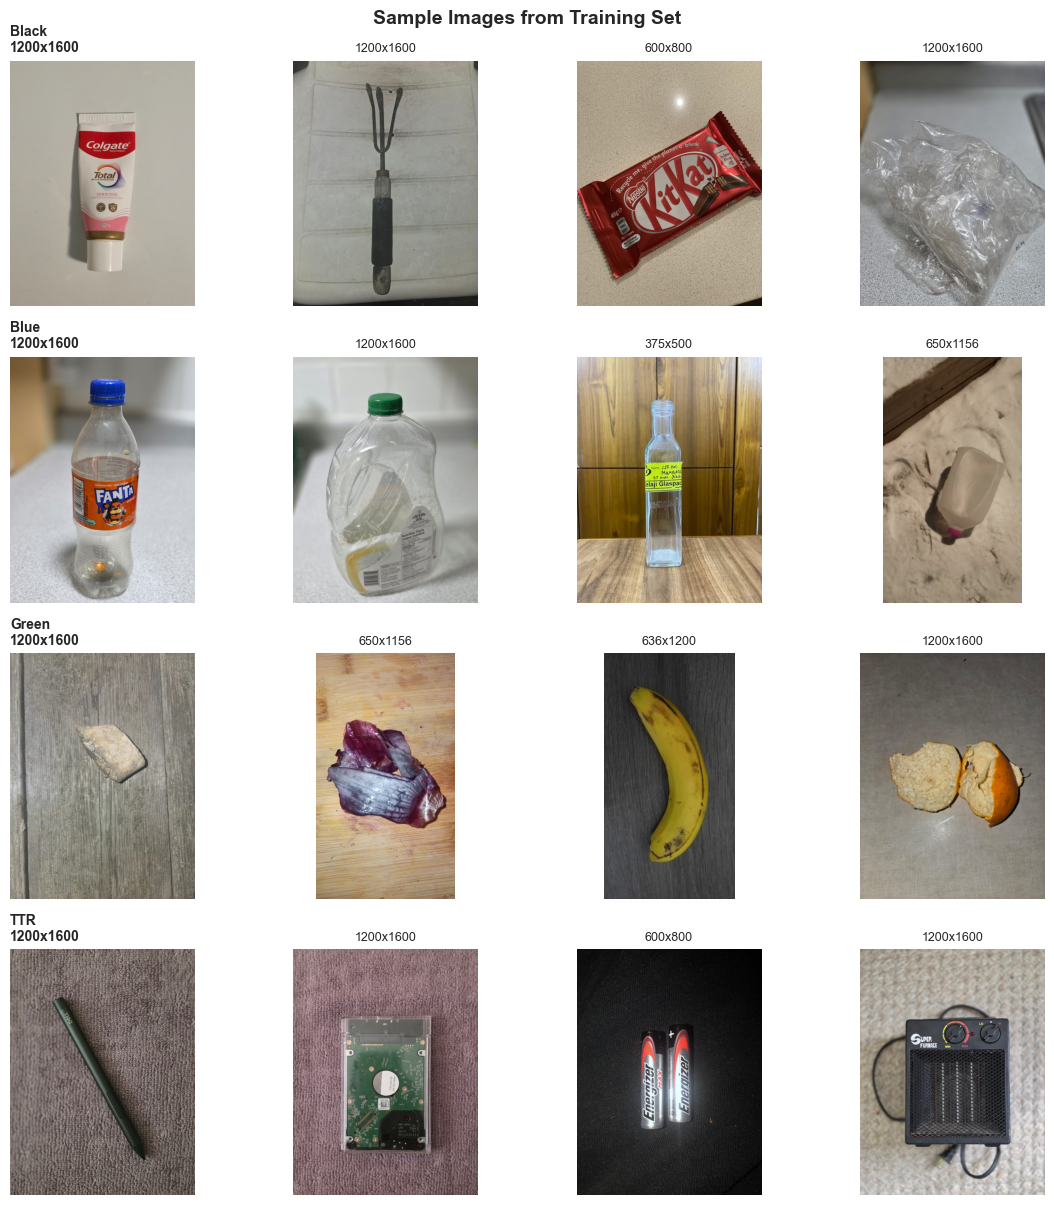

In [ ]:
# Display sample images from each class
def show_samples(directory, samples_per_class=4):
    """Display sample images from each class."""
    fig, axes = plt.subplots(
        len(class_names),
        samples_per_class,
        figsize=(samples_per_class * 3, len(class_names) * 3),
    )

    for class_idx, class_name in enumerate(class_names):
        class_dir = directory / class_name
        image_files = (
            list(class_dir.glob("*.jpg"))
            + list(class_dir.glob("*.jpeg"))
            + list(class_dir.glob("*.png"))
        )

        # Get random samples
        np.random.seed(42)  # For reproducibility
        sample_files = np.random.choice(
            image_files, min(samples_per_class, len(image_files)), replace=False
        )

        for img_idx, img_path in enumerate(sample_files):
            try:
                img = Image.open(img_path)

                if len(class_names) == 1:
                    ax = axes[img_idx]
                else:
                    ax = axes[class_idx, img_idx]

                ax.imshow(img)
                ax.axis("off")

                if img_idx == 0:
                    ax.set_title(
                        f"{class_name}\n{img.size[0]}x{img.size[1]}",
                        fontweight="bold",
                        fontsize=10,
                        loc="left",
                    )
                else:
                    ax.set_title(f"{img.size[0]}x{img.size[1]}", fontsize=9)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    plt.tight_layout()
    plt.suptitle(
        "Sample Images from Training Set", fontsize=14, fontweight="bold", y=1.00
    )
    plt.show()


show_samples(train_dir, samples_per_class=4)

## 4. Data Loading with PyTorch

### 4.1 Define Data Transformations

In [20]:
# Custom transform to resize and pad images while maintaining aspect ratio
class ResizeAndPad(torch.nn.Module):
    """Resize image to target size while maintaining aspect ratio, then pad to square."""

    def __init__(self, target_size, fill=0):
        super(ResizeAndPad, self).__init__()
        self.target_size = target_size
        self.fill = fill

    def forward(self, img):
        # Get original dimensions
        w, h = img.size

        # Calculate scaling factor (resize so smaller dimension equals target_size)
        scale = self.target_size / min(w, h)
        new_w = int(w * scale)
        new_h = int(h * scale)

        # Resize image maintaining aspect ratio
        img = transforms.Resize((new_h, new_w))(img)

        # Calculate padding needed to make it square
        pad_w = self.target_size - new_w
        pad_h = self.target_size - new_h

        # Pad to make square (center the image)
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        img = transforms.Pad(padding, fill=self.fill)(img)

        return img

In [ ]:
# ImageNet normalization values (for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Image size for MobileNetV3
IMG_SIZE = 224


# Training transformations with data augmentation
train_transform = transforms.Compose(
    [
        ResizeAndPad(IMG_SIZE, fill=0),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(
            degrees=0, translate=(0.1, 0.1)
        ),  # Affine transformation is basically a combination of translation, scaling, and shearing. Here we are applying only translation to simulate slight shifts in the image, which can help the model generalize better to variations in object positioning.
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

# Validation and test transformations (no augmentation)
val_test_transform = transforms.Compose(
    [
        ResizeAndPad(IMG_SIZE, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

print("Data transformations defined:")
print(f"- Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"- Resize strategy: Maintain aspect ratio + pad to square")
print(f"- Normalization: ImageNet stats")
print(f"- Training augmentation: Flip, Rotation, ColorJitter, Affine")

Data transformations defined:
- Image size: 224x224
- Resize strategy: Maintain aspect ratio + pad to square
- Normalization: ImageNet stats
- Training augmentation: Flip, Rotation, ColorJitter, Affine


### 4.2 Create Dataset and DataLoader Objects

In [28]:
# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Batch size
BATCH_SIZE = 32

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows, increase for Linux/Mac if needed
    pin_memory=True if torch.cuda.is_available() else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
)

print("DataLoaders created successfully!")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Train batches: {len(train_loader)}")
print(f"- Val batches: {len(val_loader)}")
print(f"- Test batches: {len(test_loader)}")
print(f"\nClass to index mapping: {train_dataset.class_to_idx}")

DataLoaders created successfully!
- Batch size: 32
- Train batches: 2
- Val batches: 1
- Test batches: 1

Class to index mapping: {'Black': 0, 'Blue': 1, 'Green': 2, 'TTR': 3}


### 4.3 Visualize Transformed Images

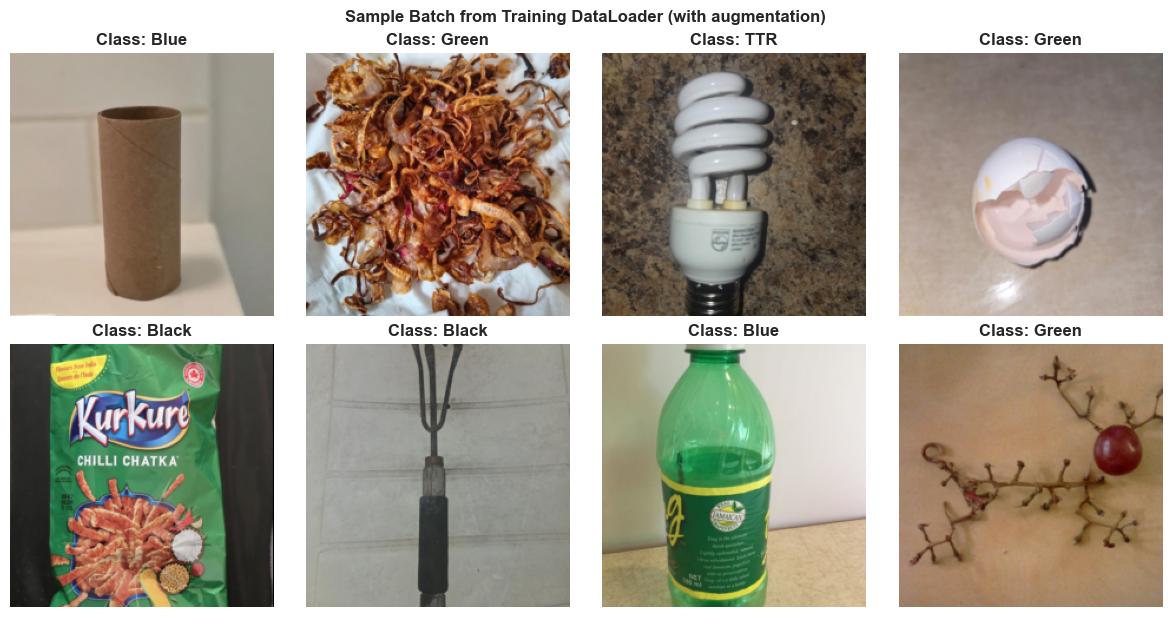

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Image dtype: torch.float32
Image range: [-2.118, 2.640]


In [29]:
# Visualize a batch of training data
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Denormalize tensor for visualization."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean


# Get a batch from training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Create index to class name mapping
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Display the first 8 images from the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(min(8, len(images))):
    # Denormalize and convert to numpy
    img = denormalize(images[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Clip to valid range

    axes[i].imshow(img)
    axes[i].set_title(f"Class: {idx_to_class[labels[i].item()]}", fontweight="bold")
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle(
    "Sample Batch from Training DataLoader (with augmentation)",
    fontsize=12,
    fontweight="bold",
    y=1.02,
)
plt.show()

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image dtype: {images.dtype}")
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")